## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

In [2]:
import time
%matplotlib inline
time.sleep(1)

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [4]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(40)

cv2.destroyAllWindows()

## Use calibrateCamera openCV function to calibrate

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [6]:
img = cv2.imread("camera_cal/calibration2.jpg")
cv2.imshow('img',img)

## Save calibration parameters for further uses

In [7]:
import pickle
pickle.dump( [mtx,dist,rvecs,tvecs], open( 'cam_cal.pkl', 'wb' ))


In [8]:
[mtx2, dist2, rvecs2, tvecs2] = pickle.load(open( "cam_cal.pkl", "rb" ))

## Verify the saved parameters and calibration.

To achive undistorsion I use opencv fucntion undistort with the data provided por calibrateCamera.

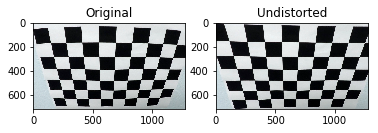

In [9]:
dst = cv2.undistort(img, mtx2, dist2, None, mtx2)
jj, axes= plt.subplots(1,2)
axes[0].imshow(img)
axes[0].set_title("Original")
axes[1].imshow(dst)
axes[1].set_title("Undistorted")
pass #avoid ugly output about title

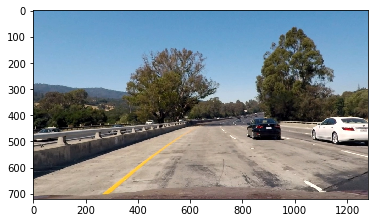

In [42]:
img = cv2.imread("test_images/test1.jpg")
dst = cv2.undistort(img, mtx2, dist2, None, mtx2)
rgb = cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)
cv2.imwrite("./output_images/undistorted-jpg.jpg",dst)
plt.imshow(rgb)
pass #avoid ugly output

In [38]:
cv2.destroyAllWindows()

# Use color transforms, gradients, etc., to create a thresholded binary image.

In [503]:
midH = 23
midS = 18
midV = 230
thr = 19

def maskHSVYellowAndWhite(orig_img):
    # Global variables for tunning process.
    global midH, midS, midV
    hsv = cv2.cvtColor(orig_img, cv2.COLOR_BGR2HSV)
    hls = cv2.cvtColor(orig_img, cv2.COLOR_BGR2HLS)
    # transform from BRG to HSV

    # get yellow mask
    maskY = cv2.inRange(hsv, np.array([22 - 3, 125 - 20, 180 - 70]), np.array([22 + 3, 125 + 90, 180 + 70]))
    # get withe mask
    #maskW = cv2.inRange(hsv, np.array([midH - 10, midS - 30, midV - 25]), np.array([midH + 10, midS + 16, midV + 25]))
    maskW = cv2.inRange(hsv, np.array([0, midS - 30, midV - 25]), np.array([176, midS + 16, midV + 25]))
    maskS = cv2.inRange(hls, np.array([0, 80, 90]), np.array([255, 255,255]))
    # to join both mask I have to do an OR between them,
    # finally make a BRG image with 255 in all dots yellow or white
    mask = np.bitwise_or(maskW, maskY)
    mask = np.bitwise_or(mask, maskS)
    mask3 = np.copy(orig_img)
    mask3[:, :, 0] = mask
    mask3[:, :, 1] = mask
    mask3[:, :, 2] = mask

    # apply mask with and bitwise operation to remove allother pixels.
    maskedImage = np.bitwise_and(mask3, orig_img)
    return maskedImage

In [325]:
def doImageProcess(image):
    # Apply blur to original image with a small kernel.
    bluredImage = cv2.GaussianBlur(image, (3, 3), 0)

    # remove all pixels that is not white or yellow
    maskedImage = maskHSVYellowAndWhite(bluredImage)
    return cv2.cvtColor(maskedImage,cv2.COLOR_HSV2BGR)

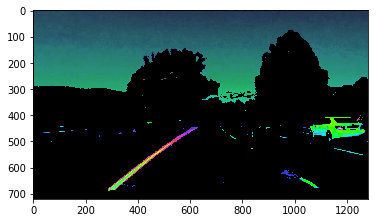

In [504]:
img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.imread("test_images/test1.jpg")
newImage = doImageProcess(img)
plt.imshow(newImage)

In [338]:
# sobel transformation
def procSobel(img,thresh_min = 20,thresh_max = 100):
    dst = cv2.undistort(img, mtx2, dist2, None, mtx2)
    rgb = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)

    sobely = cv2.Sobel(rgb, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)
    sobelx = cv2.Sobel(rgb, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobelx)
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
    return sxbinary, sybinary
    


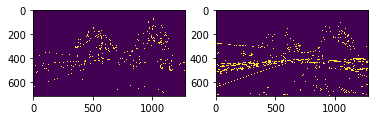

In [364]:
sx, sy = procSobel(img,40,250)
j, axes = plt.subplots(1,2)
axes[0].imshow(sx)
axes[1].imshow(sy)

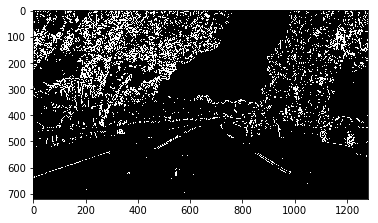

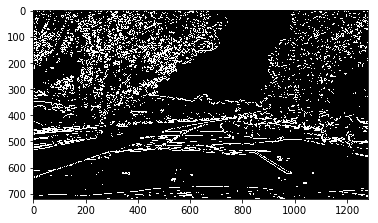

In [335]:
plt.imshow(sybinary, cmap='gray')

# Perspective transformation

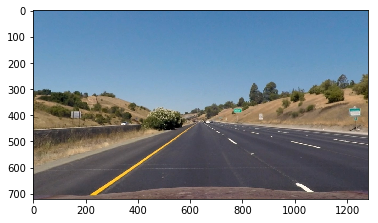

In [276]:
#first we take one example with line straigth as test_images/straight_lines1.jpg
# and apply undistorted filter
imgOrg = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.undistort(imgOrg,mtx2,dist2,None,mtx2)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

pass

In [286]:
org=np.float32([[300,660],[1010,660],[700,460],[586,460]])
#dst=np.float32([[700,0],[350,0],[350,2900],[700,2900]])
dst=np.float32([[300,700],[1010,700],[1010,120],[300,120]])


In [287]:
cv2.fillPoly(img,[org.astype(int)],1)
pass

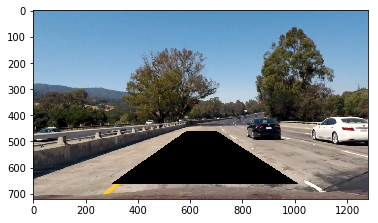

In [288]:
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
cv2.imshow("otra",img)
cv2.imwrite("./output_images/perspCalImage.jpg",img)
cv2.waitKey(400) # 0 for kay undefinily
pass

In [289]:
def getTransform(org, dst):
    M = cv2.getPerspectiveTransform(org, dst)
    return M
    

In [290]:
M=getTransform(org,dst)
Minv=getTransform(dst,org)

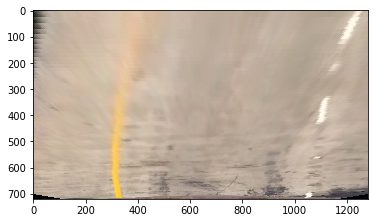

In [368]:
imgOrg = cv2.imread("test_images/test1.jpg")
img = cv2.undistort(imgOrg,mtx2,dist2,None,mtx2)
warped = cv2.warpPerspective(img, M,(img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
cv2.imwrite("./output_images/perspTransformed.jpg",warped)

pass

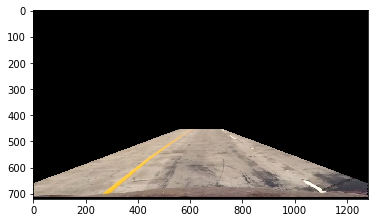

In [292]:
restored = cv2.warpPerspective(warped, Minv,(img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
plt.imshow(cv2.cvtColor(restored,cv2.COLOR_BGR2RGB))
cv2.imwrite("./output_images/persRestored.jpg",restored)
pass

# Indentify Lane-line and modelize

With whe code matrix M of the previous section and the transformation of the iamge using color transformation and 

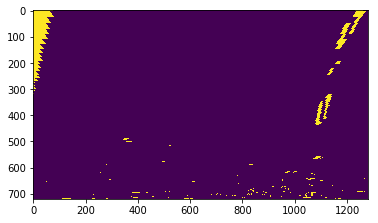

In [367]:

warped = cv2.warpPerspective(sy, M,(sy.shape[1], sy.shape[0]), flags=cv2.INTER_NEAREST)
plt.imshow(warped)

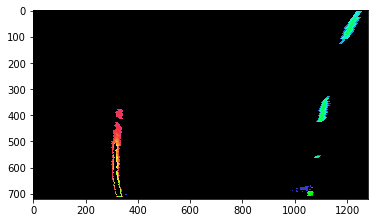

In [366]:
warped = cv2.warpPerspective(newImage, M,(newImage.shape[1], newImage.shape[0]), flags=cv2.INTER_NEAREST)
plt.imshow(warped)

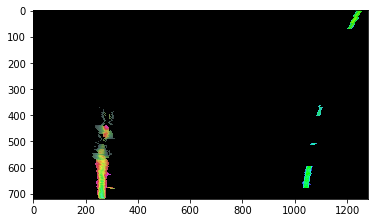

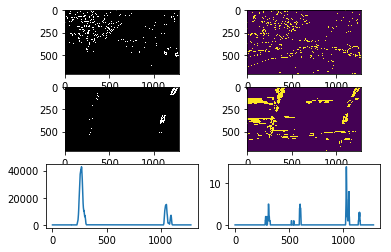

In [484]:
imgOrg = cv2.imread("test_images/test5.jpg")
img = cv2.undistort(imgOrg,mtx2,dist2,None,mtx2)
warped = cv2.warpPerspective(img, M,(img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
plt.imshow(doImageProcess(warped))
sx, sy = procSobel(img,40,250)
j, axes = plt.subplots(3,2)
axes[0][0].imshow(sx,cmap='gray')
axes[0][1].imshow(sy)
axes[1][0].imshow(cv2.warpPerspective(sx, M,(sx.shape[1], sx.shape[0]), flags=cv2.INTER_NEAREST),cmap='gray')
psx = cv2.warpPerspective(sy, M,(sy.shape[1], sy.shape[0]), flags=cv2.INTER_NEAREST)
axes[1][1].imshow(psx)
import numpy as np
img=cv2.cvtColor(doImageProcess(warped),cv2.COLOR_BGR2GRAY)
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
axes[2][0].plot(histogram)
a=30
histogram = np.sum(psx[-a-20:-a,:], axis=0)
axes[2][1].plot(histogram)

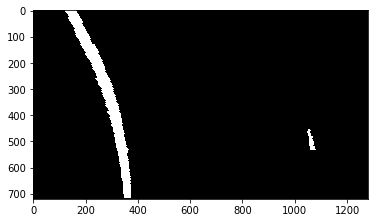

In [385]:
midH = 23
midS = 18
midV = 230
thr = 19
imgOrg = cv2.imread("test_images/test2.jpg")
img = cv2.undistort(imgOrg,mtx2,dist2,None,mtx2)
warped = cv2.warpPerspective(img, M,(img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
maskW = cv2.inRange(hls, np.array([0, 0, 90]), np.array([255, 255,255]))
plt.imshow(maskW,cmap="gray")

In [459]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
imgOrg = cv2.imread("test_images/test6.jpg")
img = cv2.undistort(imgOrg,mtx2,dist2,None,mtx2)
warped = cv2.warpPerspective(img, M,(img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
warped = doImageProcess(warped)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [460]:
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

ValueError: object too deep for desired array

In [560]:
imgOrg = cv2.imread("test_images/test1.jpg")
img = cv2.undistort(imgOrg,mtx2,dist2,None,mtx2)
warped = cv2.warpPerspective(img, M,(img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
binary_warped = cv2.cvtColor(doImageProcess(warped),cv2.COLOR_BGR2GRAY)

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image/
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

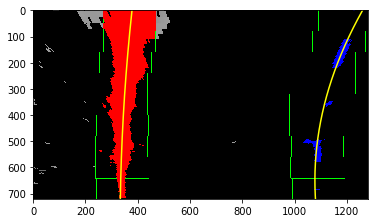

In [542]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

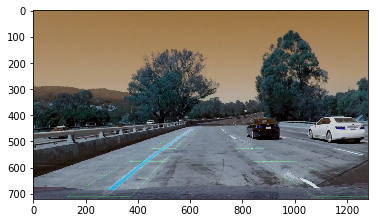

In [561]:
imgout= cv2.warpPerspective(out_img, Minv,(out_img.shape[1], out_img.shape[0]), flags=cv2.INTER_NEAREST)
cv2.addWeighted( imgOrg, .8, imgout, .2, 0.0, dst);
plt.imshow(dst)

In [562]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [587]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
#cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

In [594]:
print(np.concatenate([left_line_pts,right_line_pts],axis=0)[0][-1])
print(left_line_pts[0][-15:])
print(left_line_pts.shape)
print(np.concatenate([left_line_pts,right_line_pts],axis=1).shape)

[ 496.90798294    0.        ]
[[ 493.63828827   14.        ]
 [ 493.86954706   13.        ]
 [ 494.10115829   12.        ]
 [ 494.33312196   11.        ]
 [ 494.56543806   10.        ]
 [ 494.79810659    9.        ]
 [ 495.03112756    8.        ]
 [ 495.26450096    7.        ]
 [ 495.4982268     6.        ]
 [ 495.73230507    5.        ]
 [ 495.96673577    4.        ]
 [ 496.20151891    3.        ]
 [ 496.43665449    2.        ]
 [ 496.6721425     1.        ]
 [ 496.90798294    0.        ]]
(1, 1440, 2)
(1, 2880, 2)


In [597]:
cv2.fillPoly(window_img, np.int_([np.concatenate([[left_line_pts[0][:720]],[right_line_pts[0][720:]]],axis=1)]), (0,255, 0))

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ..., 
       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,

(720, 0)

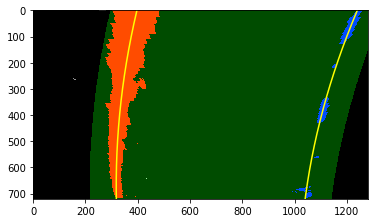

In [598]:
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

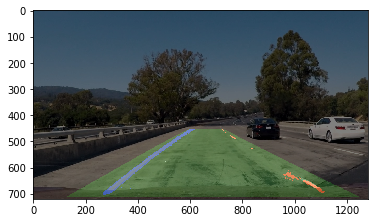

In [599]:
imgout= cv2.warpPerspective(result, Minv,(result.shape[1], result.shape[0]), flags=cv2.INTER_NEAREST)
cv2.addWeighted( imgOrg, .5, imgout, .5, 0.0, dst);
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))

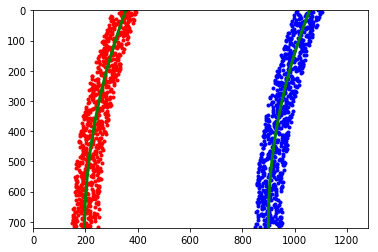

In [539]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images